In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.linalg
import scipy.integrate
import scipy.signal
import matplotlib.cm

## Goodwin's Oscillator

We will examine how the amplitude and period are affected by each parameter in the system. Each state is produced at a rate proportional to $\alpha_{1,2,3}$ and destroyed at a rate proportional to $\gamma_{1,2,3}$. Z down-regulates X with activation threshold $K$ and Hill coefficient $n$.

<div style="max-width:200px;margin-left: auto; margin-right: auto;">
    
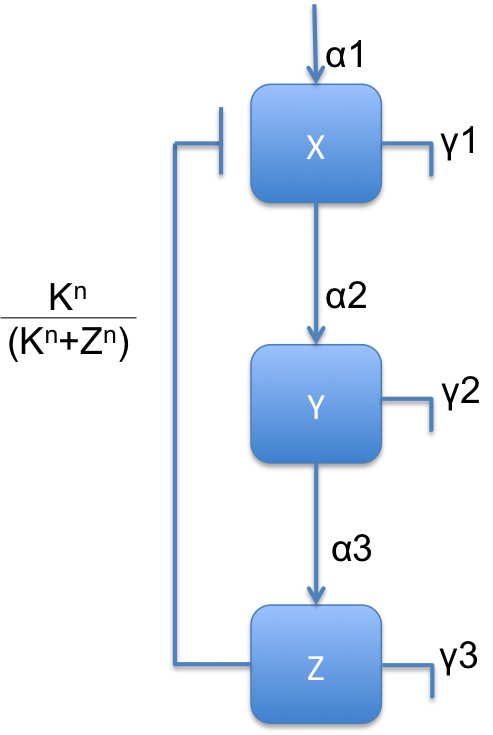
</div>

In [7]:
def goodwin_oscillator( t, statevars, params ):
    X = statevars[0];
    Y = statevars[1];
    Z = statevars[2];
    alpha_1 = params[0]
    K = params[1]
    n = params[2]
    gamma_1 = params[3]
    alpha_2 = params[4]
    gamma_2 = params[5]
    alpha_3 = params[6]
    gamma_3 = params[7]
        
    dydt = np.zeros( (3,) )
    dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X
    dydt[1] = alpha_2*X - gamma_2*Y;
    dydt[2] = alpha_3*Y - gamma_3*Z;

    return dydt


def get_period(t,x):
    """ Approximate the period of a 1-D x, given the time-steps t.
        Returns a tuple with the period and the standard deviation of the period over time.
        if the value of the standard deviation is not smaller than 0.1, then
        it means the period estimate is dodgy and you shouldn't use it. Instead,
        plot your simulation and figure out why it isn't periodic - maybe it just
        hasn't reached the limit cycle yet."""
    idxs = scipy.signal.find_peaks(x)
    idxs = idxs[0]
    times = t[idxs]
    period = np.mean(np.diff(times));
    sdperiod = np.sqrt(np.var(np.diff(times)));
    return (period,sdperiod)

def simulate_goodwin( params, t0=0, tStop=240, dt=0.1 ):
    yinit = np.ones((3,));
    sol = scipy.integrate.solve_ivp(fun=goodwin_oscillator, t_span=(0,10*24), y0=yinit, method='RK45', 
                                    t_eval=np.arange(0,10*24,0.1), args=[params] )
    sol = scipy.integrate.solve_ivp(fun=goodwin_oscillator, t_span=(0,10*24), y0=sol.y[:,-1], method='RK45', 
                                    t_eval=np.arange(t0,tStop,dt), args=[params], rtol=1e-8 )

    return sol

def goodwin_period( params ):
    """ Return the period of Goodwin's oscillator when simulated with the given parameters. """
    sol = simulate_goodwin( params )
    (per,sdper) = get_period( sol.t, sol.y[0,:] )
    return per

### Write a function to compute the amplitude of the Goodwin oscillator

The input should be the paras and which_state. which_state should be the index of the state for which we want to compute the amplitude. If which_state is -1, then compute the amplitude of all the states, and return the sum.

In [8]:
def goodwin_amplitude( params, which_state=-1 ):
    """ Return the amplitude of the given state or of the sum of all three states
        If which_state  == -1, then return the sum of all 3.
        Otherwise, which_state should be 0 (for M), 1 (for P), or 2 (for I)
    """
    sol = simulate_goodwin( params )
    if which_state == -1:
        return np.sum(sol.y.max(axis=1)-sol.y.min(axis=1))
    else:
        return sol.y[which_state,:].max() - sol.y[which_state,:].min()


### Compute the period and amplitude of the Goodwin oscillator with published parameters

period 22.240000000000002
amplitude of X 0.078766758608702
amplitude of Y 0.22063799095092582
amplitude of Z 0.5787024185615389
amplitude of X+Y+Z 0.8781071681211667


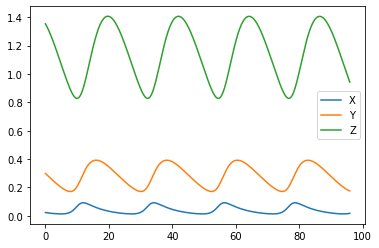

In [29]:
alpha_1 = 1
K = 0.61
n = 11
gamma_1 = 0.15
alpha_2 = 1
gamma_2 = 0.15
alpha_3 = 1
gamma_3 = 0.25

pub_params = [alpha_1,K,n,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3]
param_names = ['alpha_1','K','n','gamma_1','alpha_2','gamma_2','alpha _3','gamma_3']

per = goodwin_period( pub_params )
print("period", per)
amp1 = goodwin_amplitude( pub_params, which_state = 0 )
print( "amplitude of X", amp1)
amp2 = goodwin_amplitude( pub_params, which_state = 1 )
print( "amplitude of Y", amp2)
amp3 = goodwin_amplitude( pub_params, which_state = 2 )
print( "amplitude of Z", amp3)
ampTot = goodwin_amplitude( pub_params, which_state = -1 )
print( "amplitude of X+Y+Z", ampTot)

sol = simulate_goodwin( pub_params, tStop=4*24)
plt.plot( sol.t, sol.y.T );
plt.legend( ["X","Y","Z"]);

### Copy your sensitivity function here

In [10]:
def sensitivity( fcn, ref_params, frac_change ):
    """
    fcn should be a handle to a function that takes a parameter set as input
        and returns a scalar as output.
    ref_params should be a 1D ndarray with the parameter set
    frac_change is the perturbation size, as a scale (i.e. the fraction by which you want to adjust the parameter by)
    """
    ref = fcn( ref_params );
    Srel = np.zeros((ref_params.size,));
    for i in range(ref_params.size):
        params = ref_params.copy();
        params[i] = (1+frac_change)*ref_params[i];
        output = fcn( params );
        Srel[i] = (output-ref)/frac_change;
    return Srel

### Compute the sensitivity of the amplitude of the first state 

Compute the sensitivity of X's amplitude to 5% perturbations in each of the parameters.

To which parameters is the amplitude sensitive? To which parameters is it insensitive?

In [32]:
Srel = sensitivity( lambda p: goodwin_amplitude( p, which_state = 0), np.array(pub_params), 0.05 )

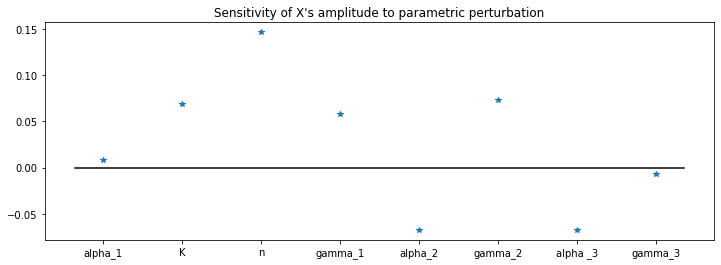

In [33]:
plt.figure(figsize=(12,4))
plt.plot( np.arange(len(pub_params)), Srel, '*')
plt.plot( plt.xlim(), [0, 0], 'k');
plt.xticks( ticks=np.arange(len(param_names)), labels=param_names);
plt.title( "Sensitivity of X's amplitude to parametric perturbation");

### Simulate the model to visualize

The sensitivity measure tells us that increasing the rate of degradation of X, we should see an increase in X's amplitude. Let's verify that nothing funky is going on. We will use a perturbation size of 10% (which is still small, but will reveal the changes more clearly than 5% would).

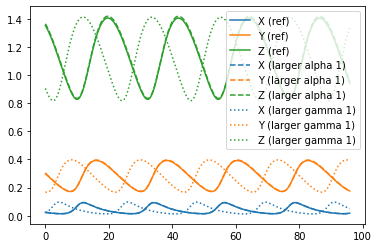

In [30]:
alpha_1 = 1
K = 0.61
n = 11
gamma_1 = 0.15
alpha_2 = 1
gamma_2 = 0.15
alpha_3 = 1
gamma_3 = 0.25

params = [alpha_1,K,n,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3]
sol = simulate_goodwin( params, tStop=24*4 )
plt.plot( sol.t, sol.y.T );
plt.gca().set_prop_cycle(None)


params = [alpha_1*1.1,K,n,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3]
sol = simulate_goodwin( params, tStop=24*4 )
plt.plot( sol.t, sol.y.T, '--' );
plt.gca().set_prop_cycle(None)


params = [alpha_1,K,n,gamma_1*1.1,alpha_2,gamma_2,alpha_3,gamma_3]
sol = simulate_goodwin( params, tStop=24*4 )
plt.plot( sol.t, sol.y.T, ':' );

plt.legend( ['X (ref)','Y (ref)','Z (ref)',
             'X (larger alpha 1)','Y (larger alpha 1)','Z (larger alpha 1)',
             'X (larger gamma 1)','Y (larger gamma 1)','Z (larger gamma 1)']);

Visualize the effects of perturbing the Hill coefficient n by 10%.

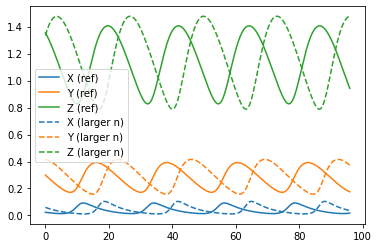

In [31]:
alpha_1 = 1
K = 0.61
n = 11
gamma_1 = 0.15
alpha_2 = 1
gamma_2 = 0.15
alpha_3 = 1
gamma_3 = 0.25

params = [alpha_1,K,n,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3]
sol = simulate_goodwin( params, tStop=24*4 )
plt.plot( sol.t, sol.y.T );
plt.gca().set_prop_cycle(None)

params = [alpha_1,K,n*1.1,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3]
sol = simulate_goodwin( params, tStop=24*4 )
plt.plot( sol.t, sol.y.T, '--' );

plt.legend( ['X (ref)','Y (ref)','Z (ref)','X (larger n)','Y (larger n)','Z (larger n)'] );

### Compare amplitude sensitivities across the three states

Compute and plot amplitude sensitivities for each state.

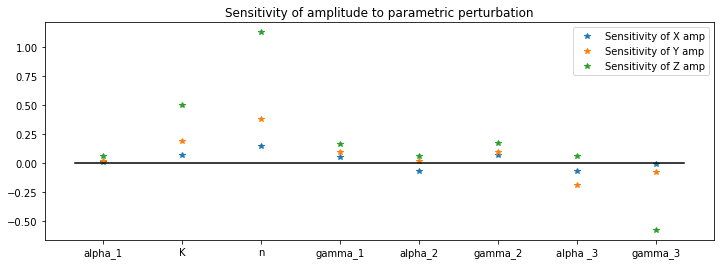

In [14]:
state_names = ['X','Y','Z']
plt.figure(figsize=(12,4))
legs = []

for i in range(len(state_names)):
    Srel = sensitivity( lambda p: goodwin_amplitude( p, which_state = i), np.array(pub_params), 0.05 )
    plt.plot( np.arange(len(pub_params)), Srel, '*')
    plt.xticks( ticks=np.arange(len(param_names)), labels=param_names);
    plt.title( "Sensitivity of amplitude to parametric perturbation" );
    legs.append( "Sensitivity of %s amp" % state_names[i])
plt.plot( plt.xlim(), [0, 0], 'k');
plt.legend( legs );

### Compare the amplitude sensitivities to the period sensitivities

Ok, I really just mean plot the period sensitivities so that we can look at the two in close proximity. What are the similarities and differences?

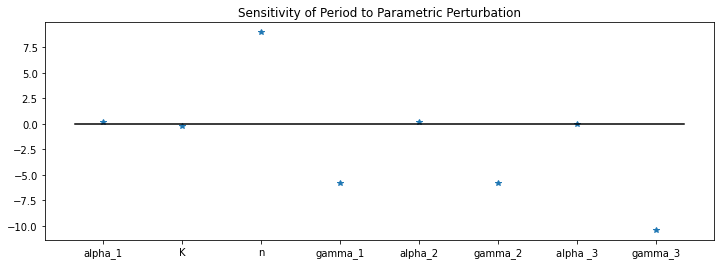

In [34]:
Srel = sensitivity( goodwin_period, np.array(pub_params), 0.05 )
plt.figure(figsize=(12,4))
plt.plot( np.arange(len(pub_params)), Srel, '*')
plt.plot( plt.xlim(), [0, 0], 'k');
plt.xticks( ticks=np.arange(len(param_names)), labels=param_names);
plt.title( "Sensitivity of Period to Parametric Perturbation");